In [1]:
from IPython.display import display, HTML
display(HTML("""
<style>
div.container{width:90% !important;}
div.cell.code_cell.rendered{width:100%;}
div.input_prompt{padding:0px;}
div.CodeMirror {font-family:Consolas; font-size:12pt;}
div.text_cell_render.rendered_html{font-size:12pt;}
div.output {font-size:12pt; font-weight:bold;}
div.input {font-family:Consolas; font-size:12pt;}
div.prompt {min-width:70px;}
div#toc-wrapper{padding-top:120px;}
div.text_cell_render ul li{font-size:12pt;padding:5px;}
table.dataframe{font-size:12px;}
</style>
"""))

In [1]:
import numpy as np
import pandas as pd

from tensorflow.keras.datasets import mnist # mnist 훈련셋과 테스트셋
from tensorflow.keras.models import Sequential # 모델 객체 생성
from tensorflow.keras.utils import to_categorical # 분류분석시 y데이터 원핫인코딩
from tensorflow.keras.layers import Input, Dense, Dropout # 모델 layer 쌓을 때 필요. 과적합시 필요
from tensorflow.keras.layers import LeakyReLU # leakyrelu는 activation='relu'처럼 leakyrelu 그대로 쓸 수 없고 %를 작성해줘야해서 import필요
from tensorflow.keras.optimizers import Adam # optimizer='adam'의 learning rate 조절가능
from tensorflow.keras.metrics import Recall, Precision # accuracy 외에 정밀도, 재현율 설정
from tensorflow.keras.models import save_model, load_model # 모델 저장, 로드
from tensorflow.keras.callbacks import Callback, EarlyStopping, ModelCheckpoint # 로그출력 간소화, epoch다 돌아가기 전에 괜찮으면 끝내는것

from sklearn.preprocessing import StandardScaler, MinMaxScaler # 정규화, 표준화
from sklearn.metrics import confusion_matrix # 혼동행렬, 교차표
from sklearn.model_selection import train_test_split # 데이터 분리

import matplotlib.pyplot as plt

# 데이터셋을 라이브러리에서 가져올 예정. 파일에서도 봄

In [2]:
data = np.loadtxt('data/mnist_train_small.csv', delimiter=',', skiprows=1) # 첫번째 행은 제외하고 데이터 가져오기(label이라서)
data.shape

(100, 785)

In [3]:
print('타겟 :', data[1,0])
# print('이미지(784pixel=28*28) :', data[1,1:].reshape(28,28)) 전체 785열중 타겟 1열 제외한 784열이 픽셀수. 
image = data[1,1:].reshape(28,28)
image.shape

타겟 : 0.0


(28, 28)

In [4]:
for row in image:
    for pixel in row:
        print('{:3.0f}'.format(pixel), end='')
    print()

  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 51159253159 50  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0 48238252252252237  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0 54227253252239233252 57  6  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0 10 60224252253252202 84252253122  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0163252252252253252252 96189253167  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0 51238253253190114253228 47 79255168  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0 48238252252179 12 75121 21  0  0253243 50  0  0  0  0  0
  0  0  0  0  0  0  0  0 38165253233208 84  0  0  0  0  0  025325

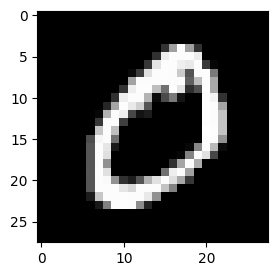

In [5]:
plt.figure(figsize=(3,3))
plt.imshow(image, cmap='gray')
plt.show()

In [6]:
%pip install opencv-python==4.8.1.78

Note: you may need to restart the kernel to use updated packages.


In [7]:
# 칼라사진 → 흑백모드 → 넘파이 배열로 읽기

import cv2
# 사진 이미지를 흑백포맷으로 넘파이 배열로 읽어오기
image_gray = cv2.imread('data/poketmon.jpg', cv2.IMREAD_GRAYSCALE) 
image_gray.shape

(180, 320)

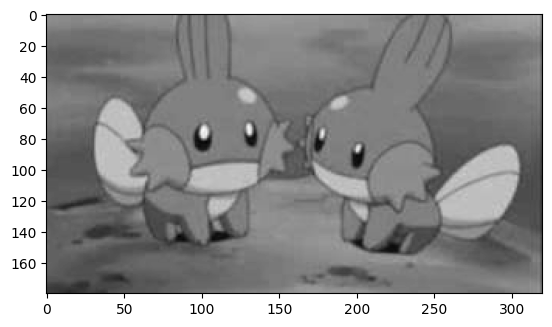

In [8]:
plt.imshow(image_gray, cmap='gray')
plt.show()

## 1. 데이터 생성 및 전처리

In [9]:
(X_train, y_train),(X_test, y_test) = mnist.load_data() # mnist만 뽑아보면 튜플로 들어가있어서 저렇게 써야함
X_train.shape, y_train.shape, X_test.shape, y_test.shape # X_train은 28*28짜리 이미지가 6만개

((60000, 28, 28), (60000,), (10000, 28, 28), (10000,))

2
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0116125171255255150 93  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0169253253253253253253218 30  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0169253253253213142176253253122  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0 52250253210 32 12  0  6206253140  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0 77251210 25  0  0  0122248253 65  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0 31 18  0  0  0  0209253253 65  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0117247253198 10  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0 76247253231 63  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0128253253144  0  0  0  0  0

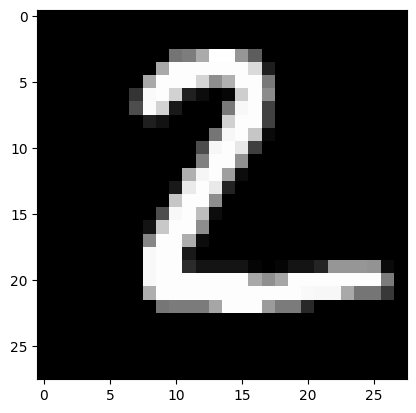

In [10]:
print(y_test[1])

for row in X_test[1]:
    for pixel in row:
        print('{:3.0f}'.format(pixel), end='')
    print()
    
plt.imshow(X_test[1], cmap='gray')
plt.show()

In [11]:
# Train데이터(6만개) → Train(5만개) + val(1만개)로 분리

X_val = X_train[50000:]
y_val = y_train[50000:]
X_train = X_train[:50000]
y_train = y_train[:50000]

In [12]:
print('학습셋 :', X_train.shape, y_train.shape)
print('검증셋 :', X_val.shape, y_val.shape)
print('시험셋 :', X_test.shape, y_test.shape)

학습셋 : (50000, 28, 28) (50000,)
검증셋 : (10000, 28, 28) (10000,)
시험셋 : (10000, 28, 28) (10000,)


In [13]:
# 입력(독립) 변수 (n,28,28) → (n, 28*28) → 실수형 변환 → 스케일조정(/255.0)

# X_train.reshape(50000, -1) 알아서 계산해줌
train_X = X_train.reshape(50000, 28*28).astype('float32')/255.0
val_X = X_val.reshape(-1, 28*28).astype('float32')/255.0
test_X = X_test.reshape(10000, -1).astype('float32')/255.0
train_X.shape, val_X.shape, test_X.shape

((50000, 784), (10000, 784), (10000, 784))

In [14]:
# 분류분석을 위한 타겟변수의 원핫인코딩

print(y_train[0])
print(to_categorical(y_train)[0])

train_Y = to_categorical(y_train, 10) # 10 : 카테고리수(안쓰면 자동계산)
val_Y = to_categorical(y_val)
test_Y = to_categorical(y_test)

train_Y.shape, val_Y.shape, test_Y.shape

5
[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]


((50000, 10), (10000, 10), (10000, 10))

In [15]:
# Train 5만개 → 700개, Val 1만개 → 300개 (목적 : 수업시간 중 fit시간 절약)

train_idx = np.random.choice(50000, 700) # 0부터 50000미만의 수 700개 뽑기. 비복원추출(중복X)
val_idx = np.random.choice(10000, 300)

train_X = train_X[train_idx]
train_Y = train_Y[train_idx]

val_X = val_X[val_idx]
val_Y = val_Y[val_idx]

In [16]:
train_X.shape, train_Y.shape, val_X.shape, val_Y.shape, test_X.shape, test_Y.shape

((700, 784), (700, 10), (300, 784), (300, 10), (10000, 784), (10000, 10))

## 2. 모델구성

In [17]:
model = Sequential()
model.add(Input(shape=(784,)))
model.add(Dense(units=2))
model.add(LeakyReLU(alpha=0.01)) # 음수결과에 대해 1%만 통과
model.add(Dense(units=10, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 2)                 1570      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 2)                 0         
                                                                 
 dense_1 (Dense)             (None, 10)                30        
                                                                 
Total params: 1,600
Trainable params: 1,600
Non-trainable params: 0
_________________________________________________________________


## 3. 학습과정 설정

In [18]:
model.compile(loss='categorical_crossentropy', # sparse_categorical_crossentropy 원핫 인코딩 안했을때 쓰는것. 자기가 원핫인코딩을 해줌
             optimizer= 'adam',
             metrics=['accuracy']) # 평가지표

## 4. 모델 학습

In [19]:
%%time
hist = model.fit(train_X, train_Y,
                epochs=200,
                batch_size=100,
                validation_data=(val_X,val_Y),
                verbose=1)

Epoch 1/200
7/7 [==============================] - 1s 39ms/step - loss: 2.2858 - accuracy: 0.1686 - val_loss: 2.2548 - val_accuracy: 0.2000
Epoch 2/200
7/7 [==============================] - 0s 8ms/step - loss: 2.2434 - accuracy: 0.2143 - val_loss: 2.2132 - val_accuracy: 0.2533
Epoch 3/200
7/7 [==============================] - 0s 6ms/step - loss: 2.2024 - accuracy: 0.2257 - val_loss: 2.1709 - val_accuracy: 0.2433
Epoch 4/200
7/7 [==============================] - 0s 6ms/step - loss: 2.1642 - accuracy: 0.2086 - val_loss: 2.1344 - val_accuracy: 0.2467
Epoch 5/200
7/7 [==============================] - 0s 6ms/step - loss: 2.1316 - accuracy: 0.2229 - val_loss: 2.0996 - val_accuracy: 0.2733
Epoch 6/200
7/7 [==============================] - 0s 7ms/step - loss: 2.1023 - accuracy: 0.2443 - val_loss: 2.0699 - val_accuracy: 0.2867
Epoch 7/200
7/7 [==============================] - 0s 6ms/step - loss: 2.0767 - accuracy: 0.2514 - val_loss: 2.0450 - val_accuracy: 0.2733
Epoch 8/200
7/7 [=========

7/7 [==============================] - 0s 8ms/step - loss: 1.2842 - accuracy: 0.5329 - val_loss: 1.4092 - val_accuracy: 0.5167
Epoch 118/200
7/7 [==============================] - 0s 7ms/step - loss: 1.2811 - accuracy: 0.5329 - val_loss: 1.4046 - val_accuracy: 0.5133
Epoch 119/200
7/7 [==============================] - 0s 5ms/step - loss: 1.2773 - accuracy: 0.5457 - val_loss: 1.4035 - val_accuracy: 0.5167
Epoch 120/200
7/7 [==============================] - 0s 6ms/step - loss: 1.2742 - accuracy: 0.5457 - val_loss: 1.4017 - val_accuracy: 0.5200
Epoch 121/200
7/7 [==============================] - 0s 6ms/step - loss: 1.2710 - accuracy: 0.5500 - val_loss: 1.3976 - val_accuracy: 0.5267
Epoch 122/200
7/7 [==============================] - 0s 8ms/step - loss: 1.2675 - accuracy: 0.5529 - val_loss: 1.3957 - val_accuracy: 0.5300
Epoch 123/200
7/7 [==============================] - 0s 7ms/step - loss: 1.2651 - accuracy: 0.5514 - val_loss: 1.3941 - val_accuracy: 0.5333
Epoch 124/200
7/7 [========

## 5. 모델 평가하기

In [20]:
hist.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

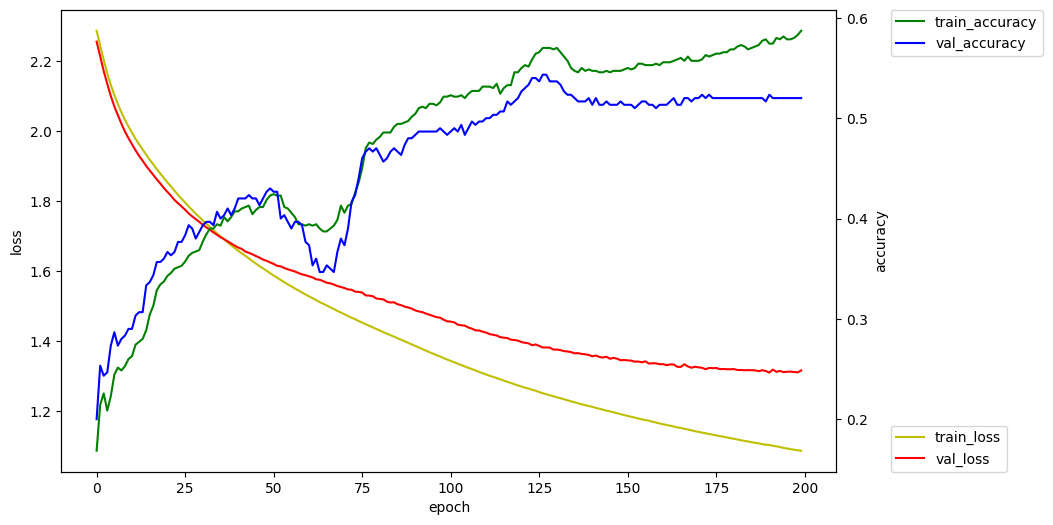

In [21]:
# 학습과정 표시하기

fig, loss_ax = plt.subplots(figsize=(10,6))
loss_ax.plot(hist.history['loss'], 'y', label='train_loss')
loss_ax.plot(hist.history['val_loss'], 'r', label='val_loss')

acc_ax = loss_ax.twinx() # loss_ax와 x축을 공유하는 acc_ax생성
acc_ax.plot(hist.history['accuracy'], 'g', label='train_accuracy')
acc_ax.plot(hist.history['val_accuracy'], 'b', label='val_accuracy')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuracy')

loss_ax.legend(bbox_to_anchor=(1.07, 0.1), loc=2, borderaxespad=0.)
acc_ax.legend(bbox_to_anchor=(1.07, 1), loc=2, borderaxespad=0.)
plt.show()

In [22]:
# 모델 평가(테스트셋)

loss_metrics = model.evaluate(test_X, test_Y, batch_size=100, verbose=0)
print('loss :', loss_metrics[0])
print('accuracy :', loss_metrics[1])

loss : 1.4335097074508667
accuracy : 0.4634999930858612


## ☝️위 모델(DNN)의 accuracy 늘리기

- 데이터 확보
- 모델 수정(레이어 추가, units수 증가)
- 과적함 방지(validation data추가, 활성화함수 relu계열, tanh계열)
- epoch 조정
- optimizer 변경

In [23]:
%%time

(X_train, y_train),(X_test, y_test) = mnist.load_data()

# Train데이터(6만개) → Train(5만개) + val(1만개)로 분리
X_val = X_train[50000:]
y_val = y_train[50000:]
X_train = X_train[:50000]
y_train = y_train[:50000]

# X_train.reshape(50000, -1) 알아서 계산해줌
train_X = X_train.reshape(50000, 28*28).astype('float32')/255.0
val_X = X_val.reshape(-1, 28*28).astype('float32')/255.0
test_X = X_test.reshape(10000, -1).astype('float32')/255.0

# 분류분석을 위한 타겟변수의 원핫인코딩
train_Y = to_categorical(y_train, 10) # 10 : 카테고리수(안쓰면 자동계산)
val_Y = to_categorical(y_val)
test_Y = to_categorical(y_test)

# 모델 생성
model = Sequential()
model.add(Input(shape=(784,)))
model.add(Dense(units=1024, activation='relu'))
model.add(Dropout(0.01))
model.add(Dense(units=512, activation='relu'))
model.add(Dropout(0.02))
model.add(Dense(units=128, activation='relu'))
model.add(Dropout(0.02))
model.add(Dense(units=32, activation='relu'))
model.add(Dropout(0.02))
model.add(Dense(units=10, activation='softmax'))
model.summary()

# 학습과정 설정
model.compile(loss='categorical_crossentropy', # sparse_categorical_crossentropy 원핫 인코딩 안했을때 쓰는것. 자기가 원핫인코딩을 해줌
             optimizer= 'adam',
             metrics=['accuracy']) # 평가지표

#모델 학습
hist = model.fit(train_X, train_Y,
                epochs=20,
                batch_size=100,
                validation_data=(val_X,val_Y),
                verbose=1)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 1024)              803840    
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_3 (Dense)             (None, 512)               524800    
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_4 (Dense)             (None, 128)               65664     
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense_5 (Dense)             (None, 32)               

In [24]:
model.evaluate(test_X, test_Y)

313/313 [==============================] - 1s 4ms/step - loss: 0.0759 - accuracy: 0.9826


[0.07593925297260284, 0.9825999736785889]

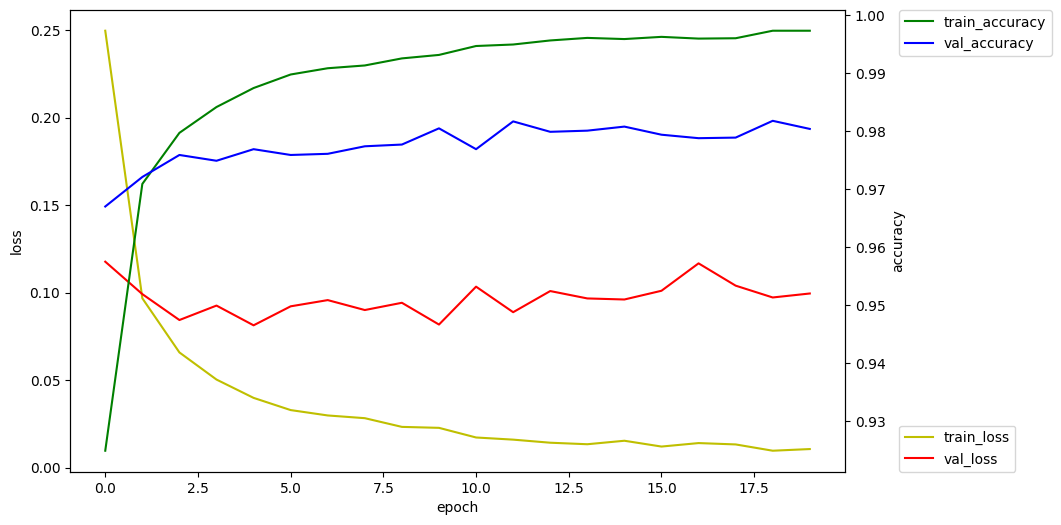

In [25]:
# 학습과정 표시하기

fig, loss_ax = plt.subplots(figsize=(10,6))
loss_ax.plot(hist.history['loss'], 'y', label='train_loss')
loss_ax.plot(hist.history['val_loss'], 'r', label='val_loss')

acc_ax = loss_ax.twinx() # loss_ax와 x축을 공유하는 acc_ax생성
acc_ax.plot(hist.history['accuracy'], 'g', label='train_accuracy')
acc_ax.plot(hist.history['val_accuracy'], 'b', label='val_accuracy')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuracy')

loss_ax.legend(bbox_to_anchor=(1.07, 0.1), loc=2, borderaxespad=0.)
acc_ax.legend(bbox_to_anchor=(1.07, 1), loc=2, borderaxespad=0.)
plt.show()

In [26]:
score = model.evaluate(test_X, test_Y)

313/313 [==============================] - 1s 4ms/step - loss: 0.0759 - accuracy: 0.9826


In [27]:
# 교차표

test_Y.argmax(axis=1) # == y_test. 실제값

array([7, 2, 1, ..., 4, 5, 6], dtype=int64)

In [28]:
# model.predict(test_X).argmax(axis=1)
y_hat = np.argmax(model.predict(test_X), axis=1) # 예측값

313/313 [==============================] - 1s 4ms/step


In [29]:
pd.crosstab(y_test, y_hat, rownames=['실제값'], colnames=['예측값'])

예측값,0,1,2,3,4,5,6,7,8,9
실제값,,,,,,,,,,
0,975,0,0,0,0,0,2,1,2,0
1,3,1115,2,2,0,1,5,4,3,0
2,3,0,1011,3,0,0,4,4,6,1
3,0,0,2,1000,0,2,0,1,5,0
4,3,0,3,0,966,0,4,2,0,4
5,2,0,0,16,1,863,4,1,5,0
6,2,2,0,1,1,1,950,0,1,0
7,0,0,5,3,1,0,0,1013,2,4
8,6,0,2,5,0,1,1,2,957,0


In [30]:
# 맞춘갯수
10000*score[1] 

# 틀린갯수
10000 - 10000*score[1]

174.00026321411133

# ※ 콜백함수1 : 로그출력

In [31]:
%%time

# 특정 에포크마다 로그출력하도록 제한

class CustomHistory(Callback):
    def __init__(self): # 생성자함수
        self.epoch = 0
    def on_epoch_end(self, batch, logs={}):
        '1 epoch마다 자동실행되는 함수'
        self.epoch += 1
        if self.epoch%10 == 0:
            print('epoch:{}, loss:{:.4f}, acc:{:.4f}, val_loss:{:.4f}, val_acc:{:.4f}'.format(
            self.epoch, logs.get('loss'), logs.get('accuracy','-'), logs.get('val_loss','-'), logs.get('val_accuracy','-')))
    
customHistory = CustomHistory()    
    
(X_train, y_train), (X_test, y_test) = mnist.load_data()

# Train데이터 6만개 => Train(5만개) + val(만개)로 분리
X_val = X_train[50000:]
y_val = y_train[50000:]
X_train = X_train[:50000]
y_train = y_train[:50000]

# 입력(독립) 변수 (n, 28, 28) -> (n, 28*28) -> 실수형변환 -> 스케일조정(/255.0)
train_X = X_train.reshape(50000, 28*28).astype('float32')/255.0
val_X   = X_val.reshape(-1, 784).astype('float32')/255.0
test_X  = X_test.reshape(10000, -1).astype('float32')/255.0

# 분류분석을 위한 타겟변수의 원핫인코딩
train_Y = to_categorical(y_train, 10) # 10:카테고리수(안쓰면 자동 입력)
val_Y   = to_categorical(y_val)
test_Y  = to_categorical(y_test)

# Train 5만->700개, Val만->300개 (목적:수업시간 중 fit시간 절약)
train_idx = np.random.choice(50000, 700) # 0~50000미만의 수 700개 비복원추출
val_idx   = np.random.choice(10000, 300)
train_X = train_X[train_idx]
train_Y = train_Y[train_idx]
val_X   = val_X[val_idx]
val_Y   = val_Y[val_idx]

# 모델 학습과정 설정
model = Sequential()
model.add(Input(shape=(784,)))
model.add(Dense(units=2, activation='relu'))
model.add(Dense(units=10, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# 모델 학습
hist = model.fit(train_X, train_Y, 
                epochs=50,
                batch_size=100,
                validation_data=(val_X, val_Y),
                verbose=0,
                callbacks=[customHistory]) # 콜백함수

epoch:10, loss:2.0905, acc:0.2443, val_loss:2.1112, val_acc:0.2300
epoch:20, loss:1.9194, acc:0.2743, val_loss:1.9661, val_acc:0.2467
epoch:30, loss:1.8141, acc:0.3057, val_loss:1.8822, val_acc:0.2833
epoch:40, loss:1.7315, acc:0.3471, val_loss:1.8144, val_acc:0.3167
epoch:50, loss:1.6620, acc:0.4000, val_loss:1.7634, val_acc:0.3567
CPU times: total: 4.27 s
Wall time: 3.5 s


# ※ 콜백함수2 : EarlyStopping

- val_loss값이 늘어나면 지정한 epoch를 다 수행하지 않고 조기 종료
- val_accuracy값이 감소하면 지정한 epoch를 다 수행하지 않고 조기 종료

In [32]:
# 모델 학습과정 설정
model = Sequential()
model.add(Input(shape=(784,)))
model.add(Dense(units=2, activation='relu'))
model.add(Dense(units=10, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# monitor 기준으로 patience번 이상 안좋은 데이터가 나오면 조기 종료
earlyStopping = EarlyStopping(monitor='val_accuracy', patience=3) 

# 모델 학습
hist = model.fit(train_X, train_Y, 
                epochs=500,
                batch_size=100,
                validation_data=(val_X, val_Y),
                verbose=1,
                callbacks=[earlyStopping]) # 콜백함수

Epoch 1/500
7/7 [==============================] - 1s 36ms/step - loss: 2.3117 - accuracy: 0.0757 - val_loss: 2.2980 - val_accuracy: 0.0567
Epoch 2/500
7/7 [==============================] - 0s 6ms/step - loss: 2.2904 - accuracy: 0.0786 - val_loss: 2.2883 - val_accuracy: 0.0833
Epoch 3/500
7/7 [==============================] - 0s 6ms/step - loss: 2.2741 - accuracy: 0.0871 - val_loss: 2.2665 - val_accuracy: 0.0700
Epoch 4/500
7/7 [==============================] - 0s 7ms/step - loss: 2.2528 - accuracy: 0.0786 - val_loss: 2.2426 - val_accuracy: 0.0800
Epoch 5/500
7/7 [==============================] - 0s 7ms/step - loss: 2.2352 - accuracy: 0.0871 - val_loss: 2.2211 - val_accuracy: 0.0800


# ※ 콜백함수3 : ModelCheckpoint

- epoch마다 val_accuracy(val_loss, accuracy, loss)값이 좋을 때 모델을 자동 저장하는 콜백

In [34]:
# 모델 학습과정 설정
model = Sequential()
model.add(Input(shape=(784,)))
model.add(Dense(units=2, activation='relu'))
model.add(Dense(units=10, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# 모델 자동저장 콜백함수
import os
model_save_folder = './model/mnist/'
if not os.path.exists(model_save_folder): # 폴더가 없으면 폴더 생성
        os.mkdir(model_save_folder)
file = model_save_folder + 'mnist-{epoch:03d}-val{val_accuracy:.4f}.h5' # 여기는 앞에 f쓰면 안된다고 하심 

checkpoint = ModelCheckpoint(
    filepath= file,
    monitor='val_accuracy', # 모니터할 지표(기본값 val_loss)
    save_best_only=True, # 모니터링 지표가 개선된 경우만 저장
    mode='max', # 값이 클수록 저장
    verbose=1 # 저장할때 표시
)

# 모델 학습
hist = model.fit(train_X, train_Y, 
                epochs=200,
                batch_size=100,
                validation_data=(val_X, val_Y),
                verbose=1,
                callbacks=[checkpoint]) # 콜백함수

Epoch 1/200
1/7 [===>..........................] - ETA: 1s - loss: 2.2919 - accuracy: 0.1700
Epoch 1: val_accuracy improved from -inf to 0.13333, saving model to ./model/mnist\mnist-001-val0.1333.h5
7/7 [==============================] - 0s 33ms/step - loss: 2.2934 - accuracy: 0.1414 - val_loss: 2.2556 - val_accuracy: 0.1333
Epoch 2/200
1/7 [===>..........................] - ETA: 0s - loss: 2.2875 - accuracy: 0.0700
Epoch 2: val_accuracy did not improve from 0.13333
7/7 [==============================] - 0s 6ms/step - loss: 2.2529 - accuracy: 0.1114 - val_loss: 2.2121 - val_accuracy: 0.1200
Epoch 3/200
1/7 [===>..........................] - ETA: 0s - loss: 2.2289 - accuracy: 0.1400
Epoch 3: val_accuracy improved from 0.13333 to 0.17667, saving model to ./model/mnist\mnist-003-val0.1767.h5
7/7 [==============================] - 0s 8ms/step - loss: 2.2098 - accuracy: 0.1543 - val_loss: 2.1761 - val_accuracy: 0.1767
Epoch 4/200
1/7 [===>..........................] - ETA: 0s - loss: 2.1909

Epoch 27/200
1/7 [===>..........................] - ETA: 0s - loss: 1.7830 - accuracy: 0.3300
Epoch 27: val_accuracy did not improve from 0.33667
7/7 [==============================] - 0s 7ms/step - loss: 1.7304 - accuracy: 0.3486 - val_loss: 1.8135 - val_accuracy: 0.3333
Epoch 28/200
1/7 [===>..........................] - ETA: 0s - loss: 1.8547 - accuracy: 0.2700
Epoch 28: val_accuracy improved from 0.33667 to 0.34000, saving model to ./model/mnist\mnist-028-val0.3400.h5
7/7 [==============================] - 0s 8ms/step - loss: 1.7213 - accuracy: 0.3543 - val_loss: 1.8051 - val_accuracy: 0.3400
Epoch 29/200
1/7 [===>..........................] - ETA: 0s - loss: 1.7098 - accuracy: 0.3700
Epoch 29: val_accuracy improved from 0.34000 to 0.34333, saving model to ./model/mnist\mnist-029-val0.3433.h5
7/7 [==============================] - 0s 12ms/step - loss: 1.7121 - accuracy: 0.3571 - val_loss: 1.7985 - val_accuracy: 0.3433
Epoch 30/200
1/7 [===>..........................] - ETA: 0s - lo

Epoch 54/200
1/7 [===>..........................] - ETA: 0s - loss: 1.5480 - accuracy: 0.4200
Epoch 54: val_accuracy did not improve from 0.41667
7/7 [==============================] - 0s 6ms/step - loss: 1.5457 - accuracy: 0.4314 - val_loss: 1.6735 - val_accuracy: 0.4167
Epoch 55/200
1/7 [===>..........................] - ETA: 0s - loss: 1.4306 - accuracy: 0.4600
Epoch 55: val_accuracy did not improve from 0.41667
7/7 [==============================] - 0s 5ms/step - loss: 1.5407 - accuracy: 0.4414 - val_loss: 1.6700 - val_accuracy: 0.4133
Epoch 56/200
1/7 [===>..........................] - ETA: 0s - loss: 1.4765 - accuracy: 0.4700
Epoch 56: val_accuracy did not improve from 0.41667
7/7 [==============================] - 0s 7ms/step - loss: 1.5358 - accuracy: 0.4443 - val_loss: 1.6680 - val_accuracy: 0.4167
Epoch 57/200
1/7 [===>..........................] - ETA: 0s - loss: 1.5660 - accuracy: 0.4900
Epoch 57: val_accuracy did not improve from 0.41667
7/7 [==============================

Epoch 84/200
1/7 [===>..........................] - ETA: 0s - loss: 1.4234 - accuracy: 0.4600
Epoch 84: val_accuracy did not improve from 0.42333
7/7 [==============================] - 0s 7ms/step - loss: 1.4088 - accuracy: 0.4643 - val_loss: 1.5852 - val_accuracy: 0.4100
Epoch 85/200
1/7 [===>..........................] - ETA: 0s - loss: 1.5112 - accuracy: 0.4800
Epoch 85: val_accuracy did not improve from 0.42333
7/7 [==============================] - 0s 6ms/step - loss: 1.4052 - accuracy: 0.4671 - val_loss: 1.5811 - val_accuracy: 0.4167
Epoch 86/200
1/7 [===>..........................] - ETA: 0s - loss: 1.5378 - accuracy: 0.3700
Epoch 86: val_accuracy did not improve from 0.42333
7/7 [==============================] - 0s 6ms/step - loss: 1.4008 - accuracy: 0.4743 - val_loss: 1.5810 - val_accuracy: 0.4167
Epoch 87/200
1/7 [===>..........................] - ETA: 0s - loss: 1.4235 - accuracy: 0.4500
Epoch 87: val_accuracy did not improve from 0.42333
7/7 [==============================

Epoch 114/200
1/7 [===>..........................] - ETA: 0s - loss: 1.4023 - accuracy: 0.4900
Epoch 114: val_accuracy improved from 0.43000 to 0.43667, saving model to ./model/mnist\mnist-114-val0.4367.h5
7/7 [==============================] - 0s 9ms/step - loss: 1.3064 - accuracy: 0.5071 - val_loss: 1.5349 - val_accuracy: 0.4367
Epoch 115/200
1/7 [===>..........................] - ETA: 0s - loss: 1.4001 - accuracy: 0.4300
Epoch 115: val_accuracy did not improve from 0.43667
7/7 [==============================] - 0s 6ms/step - loss: 1.3034 - accuracy: 0.5100 - val_loss: 1.5343 - val_accuracy: 0.4233
Epoch 116/200
1/7 [===>..........................] - ETA: 0s - loss: 1.2772 - accuracy: 0.4600
Epoch 116: val_accuracy did not improve from 0.43667
7/7 [==============================] - 0s 7ms/step - loss: 1.3008 - accuracy: 0.5100 - val_loss: 1.5343 - val_accuracy: 0.4300
Epoch 117/200
1/7 [===>..........................] - ETA: 0s - loss: 1.2547 - accuracy: 0.5000
Epoch 117: val_accurac

Epoch 171/200
1/7 [===>..........................] - ETA: 0s - loss: 1.0571 - accuracy: 0.7000
Epoch 171: val_accuracy did not improve from 0.50667
7/7 [==============================] - 0s 8ms/step - loss: 1.1448 - accuracy: 0.6200 - val_loss: 1.4703 - val_accuracy: 0.4900
Epoch 172/200
1/7 [===>..........................] - ETA: 0s - loss: 1.0964 - accuracy: 0.6300
Epoch 172: val_accuracy did not improve from 0.50667
7/7 [==============================] - 0s 9ms/step - loss: 1.1426 - accuracy: 0.6171 - val_loss: 1.4676 - val_accuracy: 0.4900
Epoch 173/200
1/7 [===>..........................] - ETA: 0s - loss: 1.0398 - accuracy: 0.6800
Epoch 173: val_accuracy did not improve from 0.50667
7/7 [==============================] - 0s 8ms/step - loss: 1.1400 - accuracy: 0.6186 - val_loss: 1.4639 - val_accuracy: 0.4933
Epoch 174/200
1/7 [===>..........................] - ETA: 0s - loss: 1.1036 - accuracy: 0.6500
Epoch 174: val_accuracy did not improve from 0.50667
7/7 [======================